## import libraries

In [1]:
import sys
!pip install torch torchvision torchtext pytorch_lightning tensorboard matplotlib tqdm wget

In [2]:
import torch
torch.cuda.is_available()
!nvidia-smi

Thu Dec  1 14:41:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 455.23.05    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:86:00.0 Off |                  Off |
| N/A   35C    P0    24W / 250W |      4MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
import numpy as np 
import csv
import os
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from torch import nn



## Load data

In [4]:
import urllib.request
import os
import zipfile
if not os.path.exists(os.getcwd()+"/ipeo_data"):
    with zipfile.ZipFile(os.getcwd()+"/ipeo_data.zip", 'r') as zip_ref:
        zip_ref.extractall()


In [5]:
train_csv = open(os.getcwd()+"/ipeo_data/splits/train.csv")
train_csv  = csv.reader(train_csv)
test_csv = open(os.getcwd()+"/ipeo_data/splits/test.csv")
test_csv  = csv.reader(test_csv)
val_csv = open(os.getcwd()+"/ipeo_data/splits/val.csv")
val_csv  = csv.reader(val_csv)
### CAREFUL need to remove the "25595_11025_label" from the validation dataset. Empty image ?
### remove direcly in the val excel fil (row = 629)

In [6]:
len(list(train_csv))

7357

## Set up the data

In [230]:
from torch.utils.data import Dataset

from PIL import Image

import os
import glob

"""CLASS rocks (1), scree (2), sparse rocks (3), water (4), glacier and permanent snow (5), forest(6), sparse forest(7),
grasslands and others (8)."""

class Alpine(Dataset):

    # mapping between label class names and indices
    LABEL_CLASSES = {
      'rocks': 		  7,
      'scree': 			    6,
      'sparse_rocks': 	  5,
      'water': 				      3,
      'glacier_and_permanent_snow': 			    4,
      'forest': 			    1,
      'sparse_forest':   2,
      'grasslands_and_others': 				    0,
      
    }

    def __init__(self, transforms=None, split='train'):
        self.transforms = transforms
        #only for label_image
        transforms_label = T.Compose([
        T.ToTensor()
        ])
        self.transforms_label = transforms_label
        
        # prepare data
        self.data = []                                  # list of tuples of (image path, label class)
        length=0
        # get images with correct index according to dataset split
        if split=='train':
            data_csv = open(os.getcwd()+"/ipeo_data/splits/train.csv")
            data_csv  = csv.reader(data_csv)
            length = 736 #736
        if split=='test':
            data_csv = open(os.getcwd()+"/ipeo_data/splits/test.csv")
            data_csv  = csv.reader(data_csv)
            length = 368
        if split=='val':
            data_csv = open(os.getcwd()+"/ipeo_data/splits/val.csv")
            data_csv  = csv.reader(data_csv)
            length = 123
            
        i=0
        print(length)
        for row in data_csv :
            if i<length:
                img_name = os.getcwd()+"/ipeo_data/rgb/"+row[0]+"_rgb.tif"
                img_label_name = os.getcwd()+"/ipeo_data/alpine_label/"+row[0]+"_label.tif"   
                i+=1
        # example format: 'baseFolder/agricultural/agricultural07.tif'
                self.data.append((
                    img_name,
                    img_label_name          # get index for label class
                ))


    #TODO: please provide the remaining functions required for the torch.utils.data.Dataset class.
    def __len__(self):
        return len(self.data)


    def __getitem__(self, x):
        img_name, img_label_name = self.data[x]
    
        img = Image.open(img_name)
        img_label = Image.open(img_label_name)
        
        
        if self.transforms is not None:
            img = self.transforms(img)
            img_label = self.transforms_label(img_label)
        return img,img_label


In [231]:
# initialize the dataset (call the constructor __init__)
import matplotlib
bounds = np.linspace(0, 7, 8)
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')


dataset = Alpine(split= "train")
print(f"dataset of length {len(dataset)}")
# plot individual samples
from ipywidgets import interact
@interact(idx=range(2000))
def plot_sample(idx=0):
    img, img_label = dataset[idx]

    plt.figure(figsize=(15, 6))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.subplot(1,2,2)
    plt.imshow(np.reshape(img_label,(200,200)), norm=norm, cmap='terrain')
    plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap="terrain"),orientation="vertical",shrink=0.6)



736
dataset of length 736


interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

In [232]:
for i in range(0,1):
    img, img_label = dataset[i]
    water = np.reshape(img_label,(200,200)).flatten()
    if len(water[water==1]) !=0:
        print(i)

## Test ( Image input 400 sur 400 / label 200 sur 200 --> need to resize the input)

### Find the mean and stf of the Dataset || No need run  anymore

In [10]:
transforms_train = T.Compose([
  T.ToTensor()
])

# dataset
train_dataset = Alpine(transforms=transforms_train, split='train')
test_dataset = Alpine(transforms=transforms_train, split='test')
val_dataset = Alpine(transforms=transforms_train, split='val')

# data loader
train_loader = DataLoader(train_dataset, 
                          batch_size  = 16, 
                          shuffle     = False, 
                          num_workers = 1,
                          pin_memory  = True)
test_loader = DataLoader(test_dataset, 
                          batch_size  = 16, 
                          shuffle     = False, 
                          num_workers = 1,
                          pin_memory  = True)
val_loader = DataLoader(val_dataset, 
                          batch_size  = 16, 
                          shuffle     = False, 
                          num_workers = 1,
                          pin_memory  = True)

def mean_std():
    ####### COMPUTE MEAN / STD

    # placeholders
    psum    = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])

    #The first two steps are done in the snippet below. Note that we set axis = [0, 2, 3] 
    #to compute mean values with respect to axis 1. The dimensions of inputs is [batch_size x 3 x image_size x image_size],
    #so we need to make sure we aggregate values per each RGB channel separately.

    # loop through images
    for img,img_label in tqdm(train_loader):
        psum    += img.sum(axis        = [0, 2, 3])
        psum_sq += (img ** 2).sum(axis = [0, 2, 3])

    for img,img_label in tqdm(test_loader):
        psum    += img.sum(axis        = [0, 2, 3])
        psum_sq += (img ** 2).sum(axis = [0, 2, 3])

    for img,img_label in tqdm(val_loader):
        psum    += img.sum(axis        = [0, 2, 3])
        psum_sq += (img ** 2).sum(axis = [0, 2, 3])

    ####### FINAL CALCULATIONS

    # image count
    s = 0
    for image in test_csv :
        s+=1
    for image in train_csv :
        s+=1
    for image in val_csv :
        s+=1
    # pixel count
    image_size = train_dataset[0][0].shape #[3,400,400]     
    count = s * image_size[1] * image_size[1]

    # mean and std
    total_mean = psum / count
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)

    # output
    print('mean: '  + str(total_mean))
    print('std:  '  + str(total_std))
    return total_mean,total_std
# mean,std = mean_std()
"""
GOT: 
mean: tensor([0.4572, 0.5079, 0.4388])
std:  tensor([0.2366, 0.2141, 0.1992])
Use in normalisze transforms

"""

736
368
123


'\nGOT: \nmean: tensor([0.4572, 0.5079, 0.4388])\nstd:  tensor([0.2366, 0.2141, 0.1992])\nUse in normalisze transforms\n\n'

## Transforms

In [11]:

# mean and standard deviation of the dataset 
mean=torch.tensor([0.4572, 0.5079, 0.4388])
std=torch.tensor([0.2366, 0.2141, 0.1992])
# normalize image [0-1] (or 0-255) to zero-mean unit standard deviation
normalize = T.Normalize(mean, std)
# we invert normalization for plotting later
std_inv = 1 / (std + 1e-7)
unnormalize = T.Normalize(-mean * std_inv, std_inv)

transforms_train = T.Compose([
  #TODO: add your own transforms here

  T.Resize((200, 200)),
  T.ToTensor(),
  normalize
])
"""
  T.RandomResizedCrop((200, 200)),
  T.RandomGrayscale(),
  T.RandomHorizontalFlip(),
  T.RandomApply([T.GaussianBlur(kernel_size=7)]),
  T.RandomPosterize(bits=8),
  T.RandomVerticalFlip(),
  T.ColorJitter(),
"""
# we do not augment the validation dataset (aside from resizing and tensor casting)
transforms_val = T.Compose([
  T.Resize((200, 200)),
  T.ToTensor(),
  normalize
])



## Model  Base on AlexNet + https://github.com/milesial/Pytorch-UNet

In [12]:
import torch.nn.functional as F
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [233]:
""" Full assembly of the parts to form the complete network """

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        self.down4 = Down(128, 256)
        self.down5 = Down(256, 512)       
        factor = 2 if bilinear else 1
        self.down6 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.up5 = Up(64, 32, bilinear)
        self.up6 = Up(32, 16, bilinear)
        
        self.outc = OutConv(16, n_classes) #initial size ! (MLP here )
        ## Note : the last step == fully connected NN (MLP) || could be repplace by a Random forest methods ! (try)

    def forward(self, x,RF=False):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)
        x7 = self.down6(x6)
        
        x = self.up1(x7, x6)
        x = self.up2(x, x5)
        x = self.up3(x, x4)
        x = self.up4(x, x3)
        x = self.up5(x, x2)
        x = self.up6(x, x1)
        
        if not RF :
            logits = self.outc(x)
            return logits
        else :
            return x

## Getloader

In [234]:
def get_dataloaders(split):
    
    
    data_dataset = Alpine(transforms=transforms_train, split=split)
    shuffle = True
    if split == "test":
        shuffle = False
    # data loader
    data_loader = DataLoader(data_dataset, 
                              batch_size  = 2, 
                              shuffle     = shuffle, 
                              num_workers = 1,
                              pin_memory  = False)
    return data_dataset, data_loader

In [15]:
 train_loader = get_dataloaders("train")[1]
len(train_loader)

736


368

In [310]:

def train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device,RF):
    ### SOLUTION
    model.train()
    loss_history = []
    accuracy_history = []
    lr_history = []
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor) #avoid an error idk why?
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, RF)
        if not RF :
            #shape with not RF : CNN + MLP : prediction already done
            #print(output.shape) #[batch,class,200,200]
            #print(target.shape)#[batch,1,200,200]
            #Newsize for criterion
            output = output.permute(1,0,2,3).flatten(1).permute(1,0) #[batch*200*200,class]
            target = target.flatten() #[batch*200*200]

        else :
            #shape with  RF : CNN + RF
            #print(output.shape) #[batch,features,200,200] .. ici features = 16
            #print(target.shape)#[batch,1,200,200]
            #RF prediction
            output = RF_CNN(output,target,nbr_class=8) #[batch*200*200,class]
            target = target.flatten() #[batch*200*200]
            print(output)
            print(output.shape)
            
            
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        predictions = output.argmax(1).cpu().detach().numpy()
        ground_truth = target.cpu().detach().numpy()
        #correct = pred.eq(target.view_as(pred)).sum().item()
        #ccuracy_float = correct / len(output[0])
        
        accuracy_float = (predictions == ground_truth).mean()
        loss_float = loss.item()

        loss_history.append(loss_float)
        accuracy_history.append(accuracy_float)
        lr_history.append(scheduler.get_last_lr()[0])
        if batch_idx % (len(train_loader.dataset) // len(data) // 10) == 0:
            print(
                f"Train Epoch: {epoch}-{batch_idx:03d} "
                f"batch_loss={loss_float:0.2e} "
                f"batch_acc={accuracy_float:0.3f} "
                f"lr={scheduler.get_last_lr()[0]:0.3e} "
            )

    return loss_history, accuracy_history, lr_history


@torch.no_grad()
def validate(model, device, val_loader, criterion,RF):
    model.eval()  # Important: eval mode (affects dropout, batch norm etc)
    test_loss = 0
    accuracy_float = 0 
    for data, target in val_loader:
        target = target.type(torch.LongTensor) #avoid an error idk why?
        data, target = data.to(device), target.to(device)
        output = model(data,RF=False)
        output = model(data, RF)
        if not RF :
            #shape with not RF : CNN + MLP : prediction already done
            #print(output.shape) #[batch,class,200,200]
            #print(target.shape)#[batch,1,200,200]
            #Newsize for criterion
            output = output.permute(1,0,2,3).flatten(1).permute(1,0) #[batch*200*200,class]
            target = target.flatten() #[batch*200*200]
        else :
            #shape with  RF : CNN + RF
            #print(output.shape) #[batch,features,200,200] .. ici features = 16
            #print(target.shape)#[batch,1,200,200]
            #RF prediction
            output = RF_CNN(output,target,nbr_class=8) #[batch*200*200,class]
            output = output.to(device)
            target = target.to(device)
            target = target.flatten() #[batch*200*200]
        
        test_loss += criterion(output, target)
        
        predictions = output.argmax(1).cpu().detach().numpy()
        ground_truth = target.cpu().detach().numpy()
        
        accuracy_float += (predictions == ground_truth).mean()

    test_loss /= len(val_loader)

    print(
        "Val set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            accuracy_float,
            len(val_loader),
            100.0 * accuracy_float / len(val_loader),
        )
    )
    return test_loss, accuracy_float / len(val_loader)


def run_training(
    model_factory,
    num_epochs,
    optimizer_kwargs,
    device="cuda",
    RF=False
):
    # ===== Data Loading =====
    train_loader = get_dataloaders("train")[1]
    val_loader = get_dataloaders("val")[1]

    # ===== Model, Optimizer and Criterion =====
    model = UNet(3,8)
    model = model.to(device=device)
    optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)
    criterion = torch.nn.functional.cross_entropy
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
    )

    # ===== Train Model =====
    lr_history = []
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc, lrs = train_epoch(
            model, optimizer, scheduler, criterion, train_loader, epoch, device,RF
        )
        train_loss_history.extend(train_loss)
        train_acc_history.extend(train_acc)
        lr_history.extend(lrs)

        val_loss, val_acc = validate(model, device, val_loader, criterion,RF)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
    
    #test part
    
    return (sum(train_acc) / len(train_acc), val_acc, model)





In [311]:
""" IF curve .. (not working)
    # ===== Plot training curves =====
    n_train = len(train_acc_history)
    t_train = num_epochs * np.arange(n_train) / n_train
    t_val = np.arange(1, num_epochs + 1)

    plt.figure(figsize=(6.4 * 3, 4.8))
    plt.subplot(1, 3, 1)
    plt.plot(t_train, train_acc_history, label="Train")
    plt.plot(t_val, val_acc_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.subplot(1, 3, 2)
    plt.plot(t_train, train_loss_history, label="Train")
    plt.plot(t_val, val_loss_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 3, 3)
    plt.plot(t_train, lr_history)
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
"""

' IF curve .. (not working)\n    # ===== Plot training curves =====\n    n_train = len(train_acc_history)\n    t_train = num_epochs * np.arange(n_train) / n_train\n    t_val = np.arange(1, num_epochs + 1)\n\n    plt.figure(figsize=(6.4 * 3, 4.8))\n    plt.subplot(1, 3, 1)\n    plt.plot(t_train, train_acc_history, label="Train")\n    plt.plot(t_val, val_acc_history, label="Val")\n    plt.legend()\n    plt.xlabel("Epoch")\n    plt.ylabel("Accuracy")\n\n    plt.subplot(1, 3, 2)\n    plt.plot(t_train, train_loss_history, label="Train")\n    plt.plot(t_val, val_loss_history, label="Val")\n    plt.legend()\n    plt.xlabel("Epoch")\n    plt.ylabel("Loss")\n\n    plt.subplot(1, 3, 3)\n    plt.plot(t_train, lr_history)\n    plt.xlabel("Epoch")\n    plt.ylabel("Learning Rate")\n'

In [314]:
from RF_from_CNN import RF_CNN

torch.cuda.empty_cache()
image_size = 400
model_factory = UNet
num_epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer_kwargs = dict(
    lr=1e-3,
    weight_decay=1e-2,
)

train_acc,val_acc,model = run_training(
    model_factory=UNet,
    num_epochs=num_epochs,
    optimizer_kwargs=optimizer_kwargs,
    device=device,
    RF=True
)

736
123
RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])
Train Epoch: 1-000 batch_loss=1.90e+00 batch_acc=0.769 lr=1.000e-03 


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 5., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 5., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 5., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 5., 0., 0.]])
tensor([[0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 5., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 5., 0., 0.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 6., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 6., 0.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 5., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 5., 0., 0.]])
tensor([[0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 5., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 5., 0., 0.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])
Train Epoch: 1-036 batch_loss=1.70e+00 batch_acc=0.718 lr=9.753e-04 


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.]])
tensor([[0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 5., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 5., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 5., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 5., 0., 0.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.]])
tensor([[0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.]])
tensor([[0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.]])
tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 7.],
        ...,
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 0., 7.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


RF_done
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.],
        [0., 0., 0.,  ..., 0., 6., 0.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
torch.Size([80000, 8])


/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(predicion_map))
/home/atexier/IPEO-project-2022/RF_from_CNNNNNNNNNNNNNNNNNNN.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicion_map = torch.tensor(predicion_map,requires_grad=True)


KeyboardInterrupt: 

## Testing the  model

In [293]:
model

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

In [20]:
!nvidia-smi

Thu Dec  1 14:45:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 455.23.05    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:86:00.0 Off |                  Off |
| N/A   39C    P0    35W / 250W |   2149MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
test_dataset,test_loader = get_dataloaders("test")

368


In [288]:
@torch.no_grad() 
def test(model, device, test_loader, criterion):
    test_loss = 0
    accuracy_float = 0 
    print(len(test_loader))
    test_pred = []
    test_ground_truth =[]
    all_acc = []
    for data, target in test_loader:
        batch_size = len(data)
        target = target.type(torch.LongTensor) #avoid an error idk why?
        data, target = data.to(device), target.to(device)
        output = model(data)
        #print(output.shape) #[batch,class,200,200]
        #print(target.shape)#[batch,1,200,200]
        output = output.permute(1,0,2,3).flatten(1).permute(1,0) #[batch*200*200,class]    
        target = target.flatten() #[batch*200*200]
   
        
        test_loss += criterion(output, target)
        
        predictions = output.argmax(1).cpu().detach().numpy()
        ground_truth = target.cpu().detach().numpy()
        
        predictions = predictions.reshape((batch_size,200,200))
        ground_truth = ground_truth.reshape((batch_size,200,200))
        
        accuracy_batch = (predictions == ground_truth).mean()
        accuracy_float += accuracy_batch
        for i in range(batch_size):            
            all_acc.append((predictions[i] == ground_truth[i]).mean())
            test_pred.append(predictions[i])
            test_ground_truth.append(ground_truth[i])
           
    test_loss /= len(test_loader.dataset)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            accuracy_float,
            len(test_loader),
            100.0 * accuracy_float / len(test_loader),
        )
    )
    return test_loss, accuracy_float / len(test_loader.dataset),test_pred,test_ground_truth,all_acc



In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.functional.cross_entropy
test_loss, test_acc,test_pred,test_ground_truth,all_acc = test(model, device, test_loader, criterion) 


184
Test set: Average loss: 1.0486, Accuracy: 102.64174999999997/184 (56%)


In [159]:
# print predictions
#test_dataset
LABEL_CLASSES = {
      'rocks': 		  7,
      'scree': 			    6,
      'sparse_rocks': 	  5,
      'water': 				      3,
      'glacier_and_permanent_snow': 			    4,
      'forest': 			    1,
      'sparse_forest':   2,
      'grasslands_and_others': 				    0,
      
    }
    
import matplotlib
print(f"dataset of length {len(test_dataset)}")
# plot individual samples
bounds = np.linspace(0, 7, 8)
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')

from ipywidgets import interact
@interact(idx=range(214))
def plot_sample(idx=0):

    img_data, img_label = test_dataset[idx][0],test_dataset[idx][1]
    img_pred = test_pred[idx]
    print(img_label.shape)
    
    plt.figure(figsize=(12, 12))
    plt.subplot(1,3,1,title="Real image")
    fig = plt.imshow(unnormalize(img_data).permute(1,2,0).cpu().detach().numpy())
    
    plt.subplot(1,3,2,title="Predict label \n accuracy "+str(all_acc[idx]))
    plt.imshow(img_pred, norm=norm, cmap='terrain')
    plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap="terrain"),orientation="vertical",shrink=0.3)
    
    plt.subplot(1,3,3,title="True label")
    plt.imshow(np.reshape(img_label,(200,200)), norm=norm, cmap='terrain')
    
    plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap="terrain"),orientation="vertical",shrink=0.3)
    




dataset of length 368


interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

In [124]:
img_data, img_label = test_dataset[5][0],test_dataset[5][1]
img_label

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 6, 6, 6],
         [0, 0, 0,  ..., 6, 6, 6],
         [0, 0, 0,  ..., 6, 6, 6]]], dtype=torch.int16)

# Confusion matrix 

In [49]:
def plot_confusion_matrix(conf_matrix):
    fig, ax = plt.subplots(figsize=(9, 9))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='x-large')
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Ground Truth', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix
all_gt_labels = np.array(test_ground_truth).flatten()
all_predictions = np.array(test_pred).flatten()
conf_matrix = confusion_matrix(all_gt_labels, all_predictions)

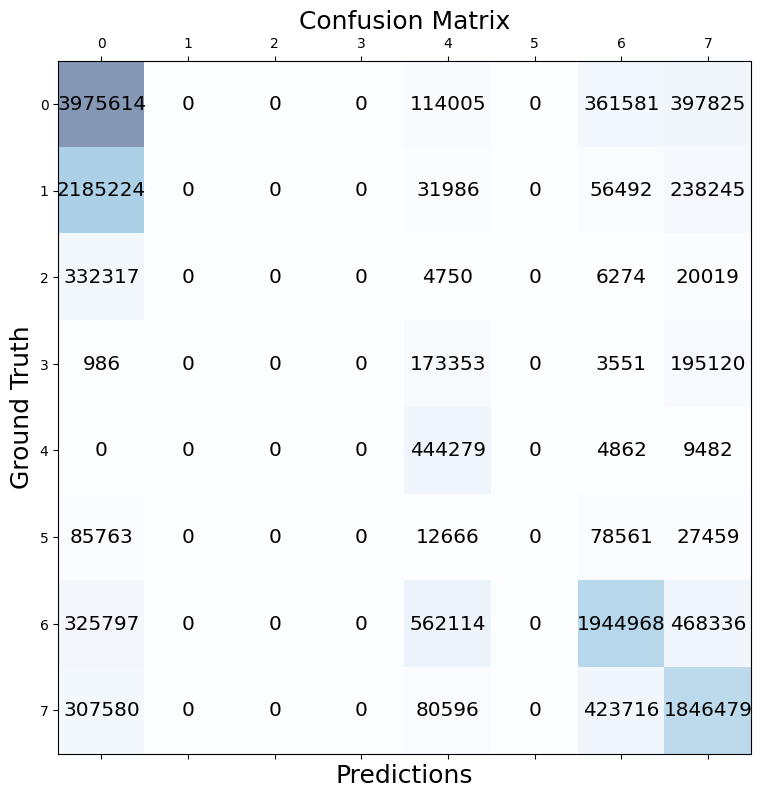

In [51]:
plot_confusion_matrix(conf_matrix)

In [58]:
len(np.where(all_gt_labels==2)[0]),len(np.where(all_predictions==3)[0])

(363360, 0)

In [226]:
LABEL_CLASSES = {
      'rocks': 		  7,
      'scree': 			    6,
      'sparse_rocks': 	  5,
      'water': 				      3,
      'glacier_and_permanent_snow': 			    4,
      'forest': 			    1,
      'sparse_forest':   2,
      'grasslands_and_others': 				    0,
      
    }
    
def data_information(conf_matrix):
    fig, ax = plt.subplots(figsize=(12, 9))
    ax.matshow(np.zeros((6,conf_matrix.shape[1])), cmap=plt.cm.Blues, alpha=1)
    for j in range(len(conf_matrix)):
        ax.text(x=j, y=0,s=np.round(np.sum(conf_matrix[j,:])/np.sum(conf_matrix),decimals=2), va='center', ha='center', size='x-large')
        ax.text(x=j, y=1,s=np.round(conf_matrix[j,j]/np.sum(conf_matrix[j,:]),decimals=2), va='center', ha='center', size='x-large')
        ax.text(x=j, y=2,s=np.round(conf_matrix[j,j]/np.sum(conf_matrix[:,j]),decimals=2), va='center', ha='center', size='x-large')
        
        
    ax.text(x=0, y=4,s=np.round(np.sum(np.diag(conf_matrix))/np.sum(conf_matrix),decimals=2), va='center', ha='center', size='x-large')
    ax.text(x=0, y=5,s=np.round(np.sum(np.diag(conf_matrix)/np.sum(conf_matrix,axis=1))/len(conf_matrix),decimals=2), va='center', ha='center', size='x-large')
    
    ax.set_yticklabels(['',"Pixel_class", "Producer_accuracy","User_accuracy", "","Overall_accuracy", "Average_accuracy"])
    ax.set_xticklabels(['',"grasslands_and_others","forest","sparse_forest","water","glacier/snow","sparse_rock","scree","rocks"])


    plt.title('data_information', fontsize=18)
    plt.show()

/home/atexier/ipeo_venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
/home/atexier/ipeo_venv/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/atexier/ipeo_venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


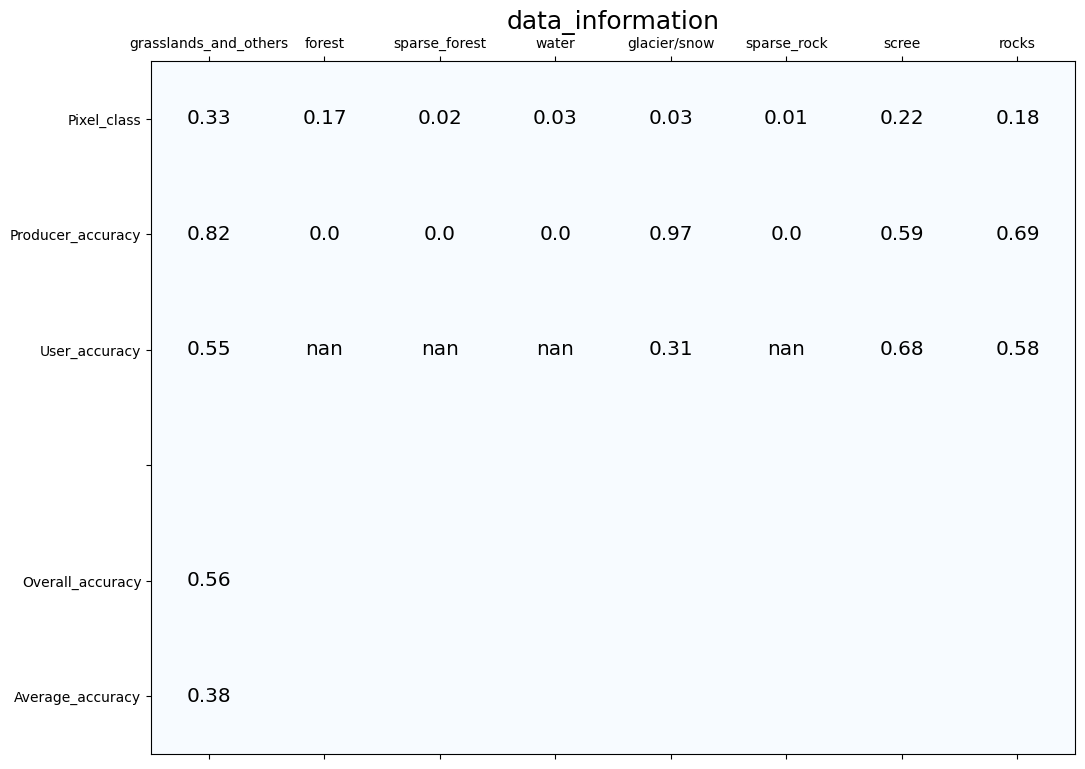

In [227]:
data_information(conf_matrix)

In [67]:
overall_acc = np.sum(np.diag(conf_matrix))/np.sum(conf_matrix)

In [203]:
np.sum(conf_matrix,axis=0)

array([7213281,       0,       0,       0, 1423749,       0, 2880005,
       3202965])

In [115]:
LABEL_class

NameError: name 'LABEL_class' is not defined